# tf.data大数据读入运行问题

很多时候，深度学习经常会出现大量的图片，这些数据非常的大，因此数据的读入与运行均十分缓慢，甚至容易运行失败。
因此，tensorflow配备着专门的数据读入与处理方式，以应对这种情况

结合下面的程序与实战，我感觉：
1. 小数据，用tf.data.Dataset.from_tensor_slices会比较方便
2. 中数据，用tf.data.Dataset.from_generator比较方便；相比tfrecord，步骤简单，不需要先创建tfrecord,然后再读取建模
3. 大数据，用tf.data.TFRecordDatasets

### 常用的数据读入格式

1. tf.data.Dataset
    - tf.data.Dataset.from_tensor()：就是原来的格式，不变更
    - tf.data.Dataset.from_tensor_slices():忽略第一行,且把各个元素分开
    
    上两者都要求数据能完整读入内存，适用于较小的数据
    - tf.data.Dataset.from_generator()：已迭代方式读入
    
2. tf.data.TFRecordDataset

    当数据较大，无法完全读入内存时，先将数据存成TFRecord形式，然后使用tf.data.TFRecordDataset()进行载入
3. tf.data.TextLineDataset
    
    每行文本变成一个元素，应该是有具体应用场景的
  

### tf.data.Dataset对应的数据处理方式

1. map(function)：对数据集的每个元素应用某个函数
2. shuffle(buffer_size):随机取样数量
3. repeat(num):数据集重复次数
4. batch(batch_size):数据集分成几个batch
5. flat_map():对数据集的每个元素应用某个函数，且将嵌套的dataset压平
6. interleave()：效果类似上者，可处理不同的数据集
7. take():截取数据集的前几个元素
8. filter():筛选掉某些元素
9. zip():将两个长度相同的数据集横向合并
10. concatenate:将两个数据集纵向合并
11. reduce:执行归并操作

### 可以提升tf.data.Dataset运行的其他设置

1. 多线程运行
    - 读取过程中多线程：interleave
    - 转换过程中多线程：map+num_parallel_calls
2. 边读取边运行：prefetch
3. 借用缓存:cache，但仅适用于数据不大的情况

### tfrecord具体的写入及处理

tfrecord是二进制，支持string,数字类型；可以高效的写入及处理数据
#### 将数据读入tfrecord
tfrecord的格式：TFRecord-->Example-->Features

数据读入的步骤：
- 通过tf.dataset.TFRecordDataset读入tfrecord文件
- 应用转化函数，将图片转化为数字矩阵

该函数
- 定义feature的字典格式
- 转化为tf.train.Example对象
- 字符串化，归一化处理

### ------------------------------------------------------------

In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_gpu_available())

2.0.0
True


### tf.data.Dataset.from_tensors与from_tensor_slices

注意两者区别：from_tensor_slices将原有的数据元素变成独立的tensor;读取numpy和pandas的时候忽略了列名（第0列）

In [2]:
ds = tf.data.Dataset.from_tensor_slices([1,2,3,4])
for line in ds:
    print(line)

tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)


In [3]:
ds2 = tf.data.Dataset.from_tensors([1,2,3,4])
for line in ds2:
    print(line)

tf.Tensor([1 2 3 4], shape=(4,), dtype=int32)


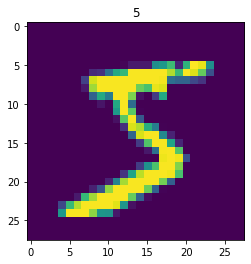

In [4]:
### read data from numpy
import numpy as np
mnist=np.load("mnist.npz")

x_train, y_train = mnist['x_train'],mnist['y_train']
x_train = np.expand_dims(x_train, axis=-1)#没有此行命令，下面的图片打印会报错

mnist_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

import matplotlib.pyplot as plt
for image, label in mnist_dataset:
    plt.title(label.numpy())
    plt.imshow(image.numpy()[:, :,0])
    plt.show()
    break

In [5]:
# read data from pandas
import pandas as pd
df = pd.read_csv('heart.csv')

In [6]:
df.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0


In [7]:
df['thal'] = pd.Categorical(df['thal'])
df['thal'] = df.thal.cat.codes #把分类变量转化成为数字

df.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,2,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,4,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


In [8]:
target = df.pop('target')
dataset = tf.data.Dataset.from_tensor_slices((df.values, target.values))

In [9]:
for feat, targ in dataset.take(3):
    print ('Features: {}, Target: {}'.format(feat, targ))

Features: [ 63.    1.    1.  145.  233.    1.    2.  150.    0.    2.3   3.    0.
   2. ], Target: 0
Features: [ 67.    1.    4.  160.  286.    0.    2.  108.    1.    1.5   2.    3.
   3. ], Target: 1
Features: [ 67.    1.    4.  120.  229.    0.    2.  129.    1.    2.6   2.    2.
   4. ], Target: 0


### tf.data.from_generator从生成器generator读入数据

适用于较大图片

In [10]:
flower_loc='./flower_photos/flower_photos/'

In [11]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20)#图片读入并解析为数字的包

In [12]:
# help(tf.keras.preprocessing.image.ImageDataGenerator)
# help(tf.data.Dataset.from_generator)

In [13]:
#带yield为生成器generator。yield就是return一个值，并且记住这个返回的位置，下次迭代会从这个位置后开始
# Gen生成器会自动地读入文件路径下面的图片，并且按照文件夹来生成标签！！！flow_from_directory确实很强大
def Gen():
    gen = img_gen.flow_from_directory(flower_loc)
    for (x,y) in gen:
        yield (x,y)
        
ds = tf.data.Dataset.from_generator(
    Gen,
    output_types=(tf.float32, tf.float32)
#     output_shapes=([32,256,256,3], [32,5])
)

In [14]:
for image,label in ds:
    print(image.shape,label.shape)
#     print(label)
    break
#？？？？我并不清楚为何图片能自动生成这个大小的数字矩阵？？？？

Found 60 images belonging to 5 classes.
(32, 256, 256, 3) (32, 5)


### TFDataSetRecord

注意：需要定义好record-->

In [15]:
train_dataset = tf.data.TFRecordDataset("sub_train.tfrecords")    # 读取 TFRecord 文件,此时的文件为图片

for xx in train_dataset:
#     print(xx)
    break

In [16]:
feature_description = { # 定义Feature结构，告诉解码器每个Feature的类型是什么
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
}

def _parse_example(example_string): # 将 TFRecord 文件中的每一个序列化的 tf.train.Example 解码
    feature_dict = tf.io.parse_single_example(example_string, feature_description)#读入的是图片
    feature_dict['image'] = tf.io.decode_jpeg(feature_dict['image'])    # 解码JPEG图片
    feature_dict['image'] = tf.image.resize(feature_dict['image'], [256, 256]) / 255.0
    return feature_dict['image'], feature_dict['label']

batch_size = 32

train_dataset = train_dataset.map(_parse_example)#运用函数，将图片转化为数字矩阵

for image,label in train_dataset:
#     print(image,label)
    break

### tf.data.Dataset的操作flat_map

In [17]:
a = tf.data.Dataset.range(1, 6)  # ==> [ 1, 2, 3, 4, 5 ]
# NOTE: New lines indicate "block" boundaries.
b=a.flat_map(lambda x: tf.data.Dataset.from_tensors(x).repeat(6)) 
for item in b:
    print(item.numpy(),end=', ')


1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 

### tf.data.Dataset的操作zip

In [22]:
a = tf.data.Dataset.range(100, 200,50) 
b = tf.data.Dataset.range(900, 800,-50) 
ds = tf.data.Dataset.zip((a, b))

In [23]:
for line in ds:
    print(line)

(<tf.Tensor: id=220, shape=(), dtype=int64, numpy=100>, <tf.Tensor: id=221, shape=(), dtype=int64, numpy=900>)
(<tf.Tensor: id=222, shape=(), dtype=int64, numpy=150>, <tf.Tensor: id=223, shape=(), dtype=int64, numpy=850>)


### tf.data.Dataset的操作concatenate

In [25]:
a = tf.data.Dataset.range(100, 200,50) 
b = tf.data.Dataset.range(900, 800,-50) 
ds = a.concatenate(b)
for line in ds:
    print(line)

tf.Tensor(100, shape=(), dtype=int64)
tf.Tensor(150, shape=(), dtype=int64)
tf.Tensor(900, shape=(), dtype=int64)
tf.Tensor(850, shape=(), dtype=int64)
